In [1]:
# !AHOCORASICK_BYTES=1 pip install git+https://github.com/WojciechMula/pyahocorasick.git

In [2]:
import time
import torch
import threading
import numpy as np
from collections import deque
from make_model import make_model
from matplotlib import pyplot as plt
from tokenizer import tokenizer,token2str,vocab_size
from train_and_use import Batch,CrossEntropyLoss,SimpleMoOptimizer,OptimizerWrapper,train_server_start
from train_and_use import text_continue
from train_and_use import TOGGLE,STOP,SET_CACULATE_SIZE
from train_and_use import record
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# %matplotlib widget

In [3]:
model = make_model(
    #token是从1开始的，0填充，剩下的用来覆盖全部字节
    vocab_size = vocab_size+1+255,
    embedding_dim = 768,
    key_dim = 128,
    head_number = 12,
    position_information_type = "mask",
    # position_information_type = "sinusoidal",
    # position_information_type = "rotary",
    # position_information_type = "learned",
    enable_affine = True,
    enable_talking_head = True,
    use_diff = False,
    self_attention_block_size = 0,
    feed_forward_dim = 1536,
    enable_layer_norm = True,
    deep = 12,
    dropout_rate = 0.1
).to(device)
parameters_n = 0
for p in model.parameters():
    parameters_n += p.data.cpu().numpy().size
print("模型参数量:"+str(parameters_n/1e9)[:4]+"(B)")

模型参数量:0.18(B)


In [4]:
#数据量
# [num,batch,length]
# [407284,32,2000]
batch_size_adjust = 0
seq_len = 64
total_lines = 13033101
skip = 0
cnt = 0
buffer = deque()
#源源不断的产生分好词的数据
def auto_tokenizer():
    global buffer
    global cnt
    with open('high_data.txt','r') as f:
        for line in f:
            #快速跳过历史
            if cnt < skip:
                cnt += 1
                continue
            buffer.append(tokenizer(line,5.0))
            cnt += 1
            #缓存的句子大小
            while len(buffer) > 2048:
                time.sleep(1)
#将分好词的数据自合成训练的批次
def data_generator(batch_size):
    global buffer
    global batch_size_adjust
    thread = threading.Thread(target=auto_tokenizer)
    thread.start()
    while len(buffer) == 0:
        time.sleep(1)
    stop = batch_size+batch_size_adjust
    data = []
    while len(buffer):
        temp = buffer.popleft()
        while len(temp) > seq_len // 2:
            data += [temp[:seq_len]]
            temp = temp[seq_len:]
            if len(data)==stop:#一个批次产出一次
                stop = batch_size+batch_size_adjust
                trunk = sorted(data,key = lambda token_list:len(token_list),reverse = True)
                trunk = [(s + [-255]*len(trunk[0]))[:min(len(trunk[0]),seq_len)] for s in trunk]
                trunk = np.array(trunk,dtype=np.int64)+255
                inputs = torch.from_numpy(trunk).to(device).data
                data = []
                print('\r{:.4f}'.format(cnt*100/total_lines),end='% ')
                yield Batch(inputs)

In [5]:
#改完参数需要检查，否则优化器可能匹配错
p_cnt = 0
def get_info():
    global p_cnt
    if p_cnt==0 or p_cnt == 303 or p.dim()==1:
        ret = 'vector'
    elif (p_cnt-1)%25 in [2,3,4] and p_cnt < 25*12:
        ret = 12,128,768
    elif p.dim()==2:
        ret = 'matrix'
    p_cnt += 1
    return ret

In [6]:
# #检查对应关系是否正确
# p_cnt = 0
# for p in model.parameters():
#     print(p_cnt,p.size(),get_info())

In [7]:
# model.load_state_dict(torch.load('large_model_5.980.weight',weights_only=True))
model.train()
loss_f = CrossEntropyLoss()
p_cnt  = 0 #重置参数计数器
optimizer = OptimizerWrapper(
    optimizer = SimpleMoOptimizer(model.parameters(),betas = (0.9,0.98),eps = 1e-7,weight_decay=1e-4,get_info=get_info),
    warm_up = 2048,
    lr = 3e-4,
    enable_wave = True
)
batch_size = 1024
caculate_size = 64
train_server_start(model,(data_generator,batch_size),caculate_size,loss_f,optimizer,use_amp = False)

13.0031% 	step: 26236 	loss: 4.729 	speed: 22811.4 tokens/s                            

In [222]:
!nvidia-smi

Sun Mar  9 12:11:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:00:08.0 Off |                  Off |
| 32%   60C    P2            389W /  450W |   17048MiB /  24564MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [239]:
print('\r{:.4f}'.format(cnt*100/total_lines),end='% ')

25.2386% 

In [242]:
TOGGLE()
# STOP()

pause: True


In [93]:
torch.cuda.empty_cache()

SET_CACULATE_SIZE(32)
seq_len = 128
batch_size_adjust = 512 - 1024

# SET_CACULATE_SIZE(16)
# seq_len = 256
# batch_size_adjust = 256 - 1024

# SET_CACULATE_SIZE(4)
# seq_len = 512
# batch_size_adjust = 128 - 1024

# SET_CACULATE_SIZE(2)
# seq_len = 1024
# batch_size_adjust = 64 - 1024

In [229]:
# optimizer.set_lrate(1e-4,8000)
# optimizer.enable_wave = False
# optimizer.enable_wave = True
# optimizer.start_step = optimizer.total_step
# batch_size_adjust = 128 - 64

In [13]:
# 64: 10% 10 batch_size:1024 3e-4
# 128:20% 30 batch_size:512  3e-4
# 256:50% 80 batch_size:256  2e-4
# 512:10% 90 batch_size:128  1e-4
# 1024:10% 95 batch_size:64  5e-5

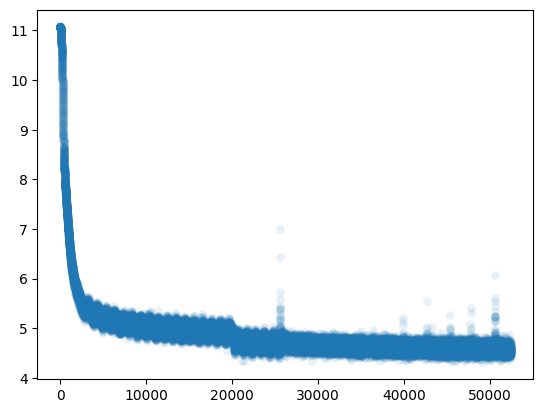

In [241]:
plt.close()
plt.scatter(list(range(len(record['loss_line']))),record['loss_line'],alpha=0.1,linewidths=0.1)
# plt.yscale('log')
# plt.plot(record['loss_line'])
plt.show()

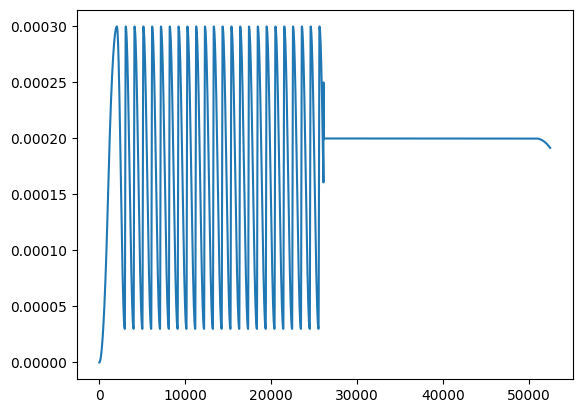

In [240]:
plt.close()
# plt.plot(record['loss_line'])
plt.plot(record['lr_line'])
plt.show()

In [219]:
# tokens_batch = [tokenizer("大家好，",5.0)]
# tokens_batch = np.array(tokens_batch,dtype=np.int64)+255
# inputs = torch.from_numpy(tokens_batch).to(device).data
# model = model.eval()
# with torch.no_grad():
#     o = text_continue(
#         model,inputs,out_length=32,
#         repeat_penalty_value = 1.0,
#         temperature = 1.0,
#         decay = 1.0
#     )
# print(token2str(o[0].cpu().numpy()-255))
# model = model.train()

In [243]:
torch.save(model.state_dict(),'large_model_'+str(cnt)+'.weight')

In [244]:
np.save('loss_line',record['loss_line'])
np.save('lr_line',record['lr_line'])